avoid any additional training and directly print results 
- determine whether the models (T_CPC or TS_CPC or S_CPC) are already capable of generating meaningful representations after the initial unsupervised/self-supervised training.

In [1]:
import wandb
from linearclassifier_all import test_extract, linearclassifier, Wearable
import itertools
import torch
from torch.utils.data import DataLoader
import numpy as np

import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


from T_CPC import T_CPC
from TS_CPC import TS_CPC
from S_CPC import S_CPC

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,6"

In [3]:
torch.backends.cudnn.deterministic = True


In [4]:
def no_train(model, type, train_loader, test_loader, device):
# def train(num_epochs, model, type, optimizer, train_loader, test_loader, device, test_every=1):

    # Directly extract representations without training
    train_c_t, train_label, _ = test_extract(model, train_loader, device)
    test_c_t, test_label, _ = test_extract(model, test_loader, device)

    # Evaluate linear classifier without updates
    accuracy, roc_auc = linearclassifier(type, train_c_t, train_label, test_c_t, test_label, log_graph=False)    # AUC-ROC, precision, F1 score, etc are saved in wandb already by the linearclassifier function
    print(f"Initial Accuracy without Training: {accuracy * 100:.2f}%")



    # Log metrics directly
    wandb.log({"initial_accuracy": accuracy})

    return accuracy, roc_auc


In [5]:
results = []

modelname=['T_CPC', 'TS_CPC', 'S_CPC']
type=['ClassifierNN', 'LogisticRegression']


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#batch_size = [256,1024]  # check that it does not influence 
batch_size = [1024]

path = '/home/ria/MMBSintern/bachelor/exercise/data' 

train_data = Wearable(path, True)
test_data = Wearable(path, False)






# Generate all combinations of modelname and batchsize
combinations = list(itertools.product(modelname, type, batch_size))

# Run each combination with each value of num_epochs

for modelname, type, bs in combinations:


    train_loader = DataLoader(train_data, batch_size=bs, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False, num_workers=0) 

    torch.manual_seed(0)
    np.random.seed(0)

        
    print(f"Running with model: {modelname}, classification: {type}, batch size: {bs}")
        
    if modelname == 'T_CPC':
        model = T_CPC(timestep=3, batch_size=bs, seq_len=200).to(device)

    elif modelname == 'TS_CPC':
        model = TS_CPC(timestep=3, batch_size=bs, seq_len=200).to(device)
    
    elif modelname == 'S_CPC':
        model = S_CPC(timestep=3, batch_size=bs, seq_len=200).to(device)

    else:
        raise ValueError(f"Unknown model name: {modelname}")

        
    config = dict( model = modelname,
                    classification = type,
                    batch_size = bs
                    )
                
            
    wandb.init(project="WITHOUT TRAINING", 
                name=f"{modelname,type,bs}",
                config=config,
                reinit=True)


    accuracy, roc_auc = no_train(model, config['classification'], train_loader, test_loader, device)

    results.append([modelname, type, bs, roc_auc])

    wandb.finish() 



# convert results to a dataframe and save as CSV
df = pd.DataFrame(results, columns=['Model','Classification','Batch Size','ROC_AUC'])
csv_filename = 'withouttrain.csv'

df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

            

Running with model: T_CPC, classification: ClassifierNN, batch size: 1024


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: riaxchoi (riaxchoi-heinrich-heine-university-d-sseldorf). Use `wandb login --relogin` to force relogin


/home/ria/miniconda3/envs/AILS/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv1d(input, weight, bias, self.stride,


Initial Accuracy without Training: 57.62%


ROC-AUC Score,▁
accuracy,▁
f1_AFib,▁
f1_non-AFib,▁
initial_accuracy,▁
precision_AFib,▁
precision_non-AFib,▁
recall_AFib,▁
recall_non-AFib,▁
ROC-AUC Score,0.61327
accuracy,0.57618


Running with model: T_CPC, classification: LogisticRegression, batch size: 1024


Initial Accuracy without Training: 55.73%


ROC-AUC Score,▁
accuracy,▁
f1_AFib,▁
f1_non-AFib,▁
initial_accuracy,▁
precision_AFib,▁
precision_non-AFib,▁
recall_AFib,▁
recall_non-AFib,▁
ROC-AUC Score,0.57584
accuracy,0.55734


Running with model: TS_CPC, classification: ClassifierNN, batch size: 1024


Initial Accuracy without Training: 66.37%


ROC-AUC Score,▁
accuracy,▁
f1_AFib,▁
f1_non-AFib,▁
initial_accuracy,▁
precision_AFib,▁
precision_non-AFib,▁
recall_AFib,▁
recall_non-AFib,▁
ROC-AUC Score,0.75069
accuracy,0.66371


Running with model: TS_CPC, classification: LogisticRegression, batch size: 1024


Initial Accuracy without Training: 67.04%


ROC-AUC Score,▁
accuracy,▁
f1_AFib,▁
f1_non-AFib,▁
initial_accuracy,▁
precision_AFib,▁
precision_non-AFib,▁
recall_AFib,▁
recall_non-AFib,▁
ROC-AUC Score,0.74084
accuracy,0.67036


Running with model: S_CPC, classification: ClassifierNN, batch size: 1024


Initial Accuracy without Training: 68.81%


ROC-AUC Score,▁
accuracy,▁
f1_AFib,▁
f1_non-AFib,▁
initial_accuracy,▁
precision_AFib,▁
precision_non-AFib,▁
recall_AFib,▁
recall_non-AFib,▁
ROC-AUC Score,0.73833
accuracy,0.68809


Running with model: S_CPC, classification: LogisticRegression, batch size: 1024


Initial Accuracy without Training: 69.20%


ROC-AUC Score,▁
accuracy,▁
f1_AFib,▁
f1_non-AFib,▁
initial_accuracy,▁
precision_AFib,▁
precision_non-AFib,▁
recall_AFib,▁
recall_non-AFib,▁
ROC-AUC Score,0.71543
accuracy,0.69197


Results saved to withouttrain.csv


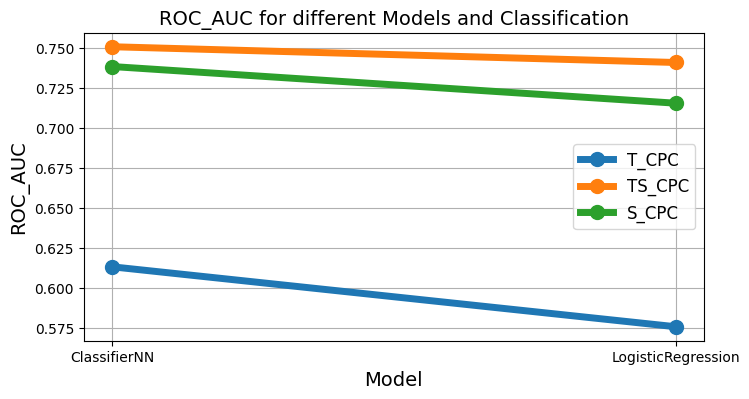

In [6]:
# Load CSV and plot results
df = pd.read_csv(csv_filename)

plt.figure(figsize=(8,4))
for model in df["Model"].unique():
    subset = df[df["Model"] == model]
    plt.plot(subset["Classification"], subset["ROC_AUC"], marker='o', linestyle='-', label=model,
             linewidth=5, markersize=10)

plt.xlabel("Model", fontsize=14)
plt.ylabel("ROC_AUC", fontsize=14)
plt.title("ROC_AUC for different Models and Classification", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("without1.png")  
plt.show()

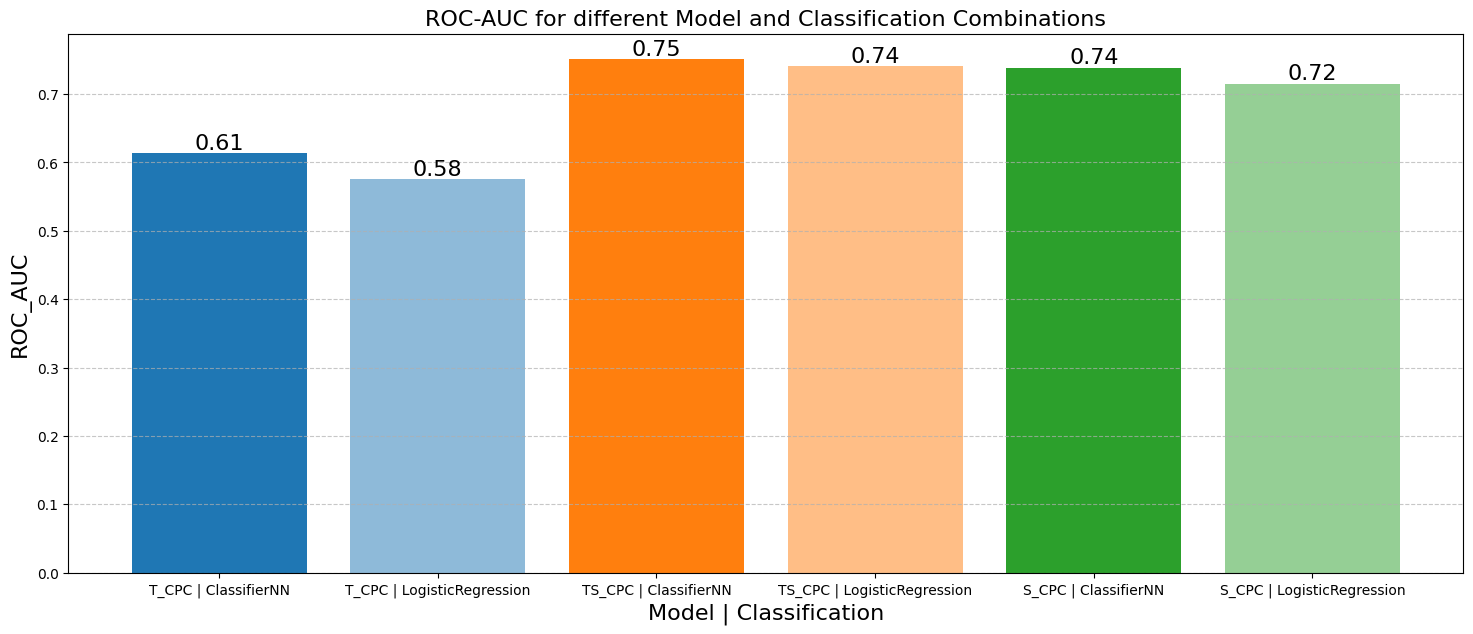

In [17]:
df = pd.read_csv(csv_filename) 

df["Label"] = df["Model"] + " | " + df["Classification"]

original = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
lighter = [mcolors.to_rgba(c, alpha=0.5) for c in original]  # Lighter shades with transparency

all=[]
for i in range(len(original)):
    all.append(original[i])
    all.append(lighter[i])
    

plt.figure(figsize=(18,7))
plt.bar(df["Label"], df["ROC_AUC"], color = all) 

plt.xlabel("Model | Classification", fontsize=16)
plt.ylabel("ROC_AUC", fontsize=16)
plt.title("ROC-AUC for different Model and Classification Combinations", fontsize=16)
# Show grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(df["ROC_AUC"]):
    plt.text(i, value, f"{value:.2f}", ha="center", va="bottom", fontsize=16)


plt.savefig("without2.png")  
plt.show()